In [241]:
import ast
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn import model_selection, linear_model, metrics
from sklearn.preprocessing import PolynomialFeatures, MultiLabelBinarizer, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, Reshape, AveragePooling2D
from keras.callbacks import EarlyStopping
from tensorflow import keras    
import seaborn as sns

## Games Dataset <br>
[kaggle](https://www.kaggle.com/datasets/arnabchaki/popular-video-games-1980-2023)

In [242]:
df = pd.read_csv('games.csv', index_col=0)
df.head()

,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,3.9K,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17K,3.8K,4.6K,4.8K
1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,2.9K,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21K,3.2K,6.3K,3.6K
2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,4.3K,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30K,2.5K,5K,2.6K
3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,3.5K,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28K,679,4.9K,1.8K
4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3K,3K,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21K,2.4K,8.3K,2.3K


### Target: Predict wishlist value 

## Frame preprocessing

In [243]:
df['Number of Reviews'].equals(df['Times Listed'])

True

In [244]:
print(df.duplicated().sum())
df = df.drop_duplicates()

382


In [245]:
df = df.drop(['Title', 'Summary', 'Reviews', 'Release Date', 'Team', 'Number of Reviews'], axis=1)
df

,Rating,Times Listed,Genres,Plays,Playing,Backlogs,Wishlist
0,4.5,3.9K,"['Adventure', 'RPG']",17K,3.8K,4.6K,4.8K
1,4.3,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",21K,3.2K,6.3K,3.6K
2,4.4,4.3K,"['Adventure', 'RPG']",30K,2.5K,5K,2.6K
3,4.2,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...",28K,679,4.9K,1.8K
4,4.4,3K,"['Adventure', 'Indie', 'Platform']",21K,2.4K,8.3K,2.3K
...,...,...,...,...,...,...,...
1507,3.2,94,"['Adventure', 'Point-and-Click']",763,5,223,67
1508,2.9,264,"['Arcade', 'Racing']",1.5K,49,413,107
1509,3.7,210,"['Brawler', 'RPG']",1.1K,45,487,206
1510,4.1,165,"['Adventure', 'RPG', 'Strategy', 'Tactical', '...",269,79,388,602


Transform Genres to list and numerical values to floats. <br>
12.4k -> 12400

In [246]:
df['Genres'] = df['Genres'].apply(ast.literal_eval)

def NumTransform(x):
    scale = 1 
    if x[-1] == 'K':
        x = x[:-1]
        scale = 1000
    x = float(x)
    return x * scale

df['Plays'] = df['Plays'].apply(NumTransform)
df['Playing'] = df['Playing'].apply(NumTransform)
df['Backlogs'] = df['Backlogs'].apply(NumTransform)
df['Wishlist'] = df['Wishlist'].apply(NumTransform)
df['Times Listed'] = df['Times Listed'].apply(NumTransform)

df.head()

,Rating,Times Listed,Genres,Plays,Playing,Backlogs,Wishlist
0,4.5,3900.0,"[Adventure, RPG]",17000.0,3800.0,4600.0,4800.0
1,4.3,2900.0,"[Adventure, Brawler, Indie, RPG]",21000.0,3200.0,6300.0,3600.0
2,4.4,4300.0,"[Adventure, RPG]",30000.0,2500.0,5000.0,2600.0
3,4.2,3500.0,"[Adventure, Indie, RPG, Turn Based Strategy]",28000.0,679.0,4900.0,1800.0
4,4.4,3000.0,"[Adventure, Indie, Platform]",21000.0,2400.0,8300.0,2300.0


In [247]:
df.isna().sum()

Rating          13
Times Listed     0
Genres           0
Plays            0
Playing          0
Backlogs         0
Wishlist         0
dtype: int64

## Frame visualization

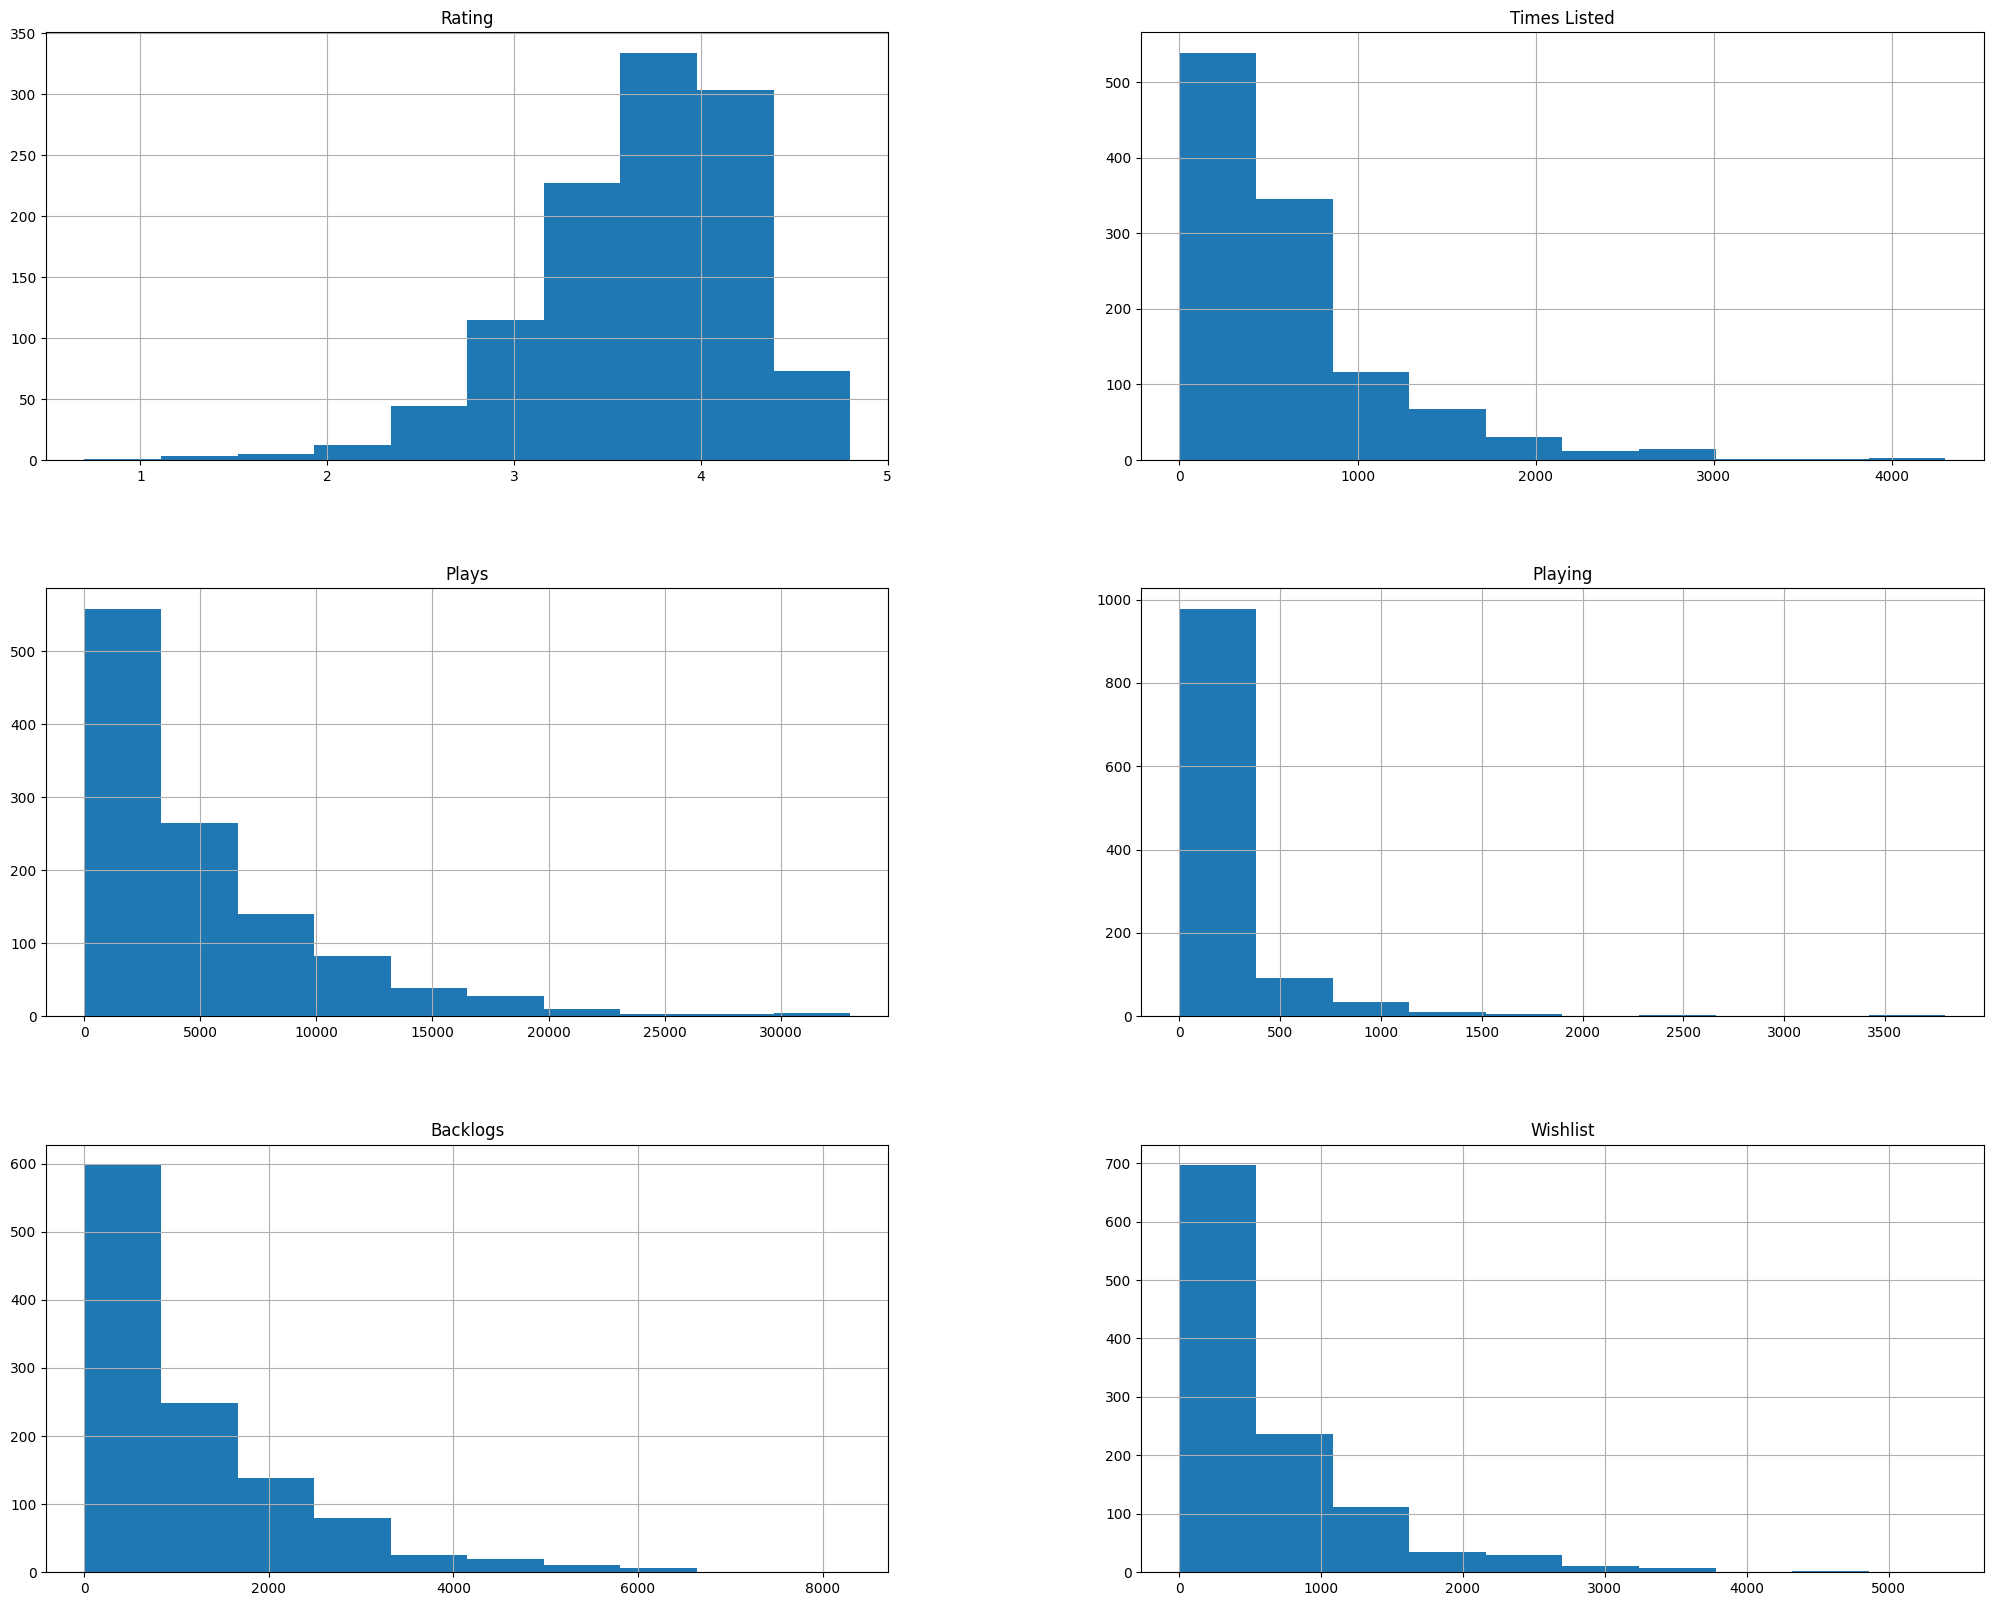

In [248]:
df.hist(figsize=(25, 20))
plt.show()

C:\Users\gapli\AppData\Local\Temp\ipykernel_10484\3359713059.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


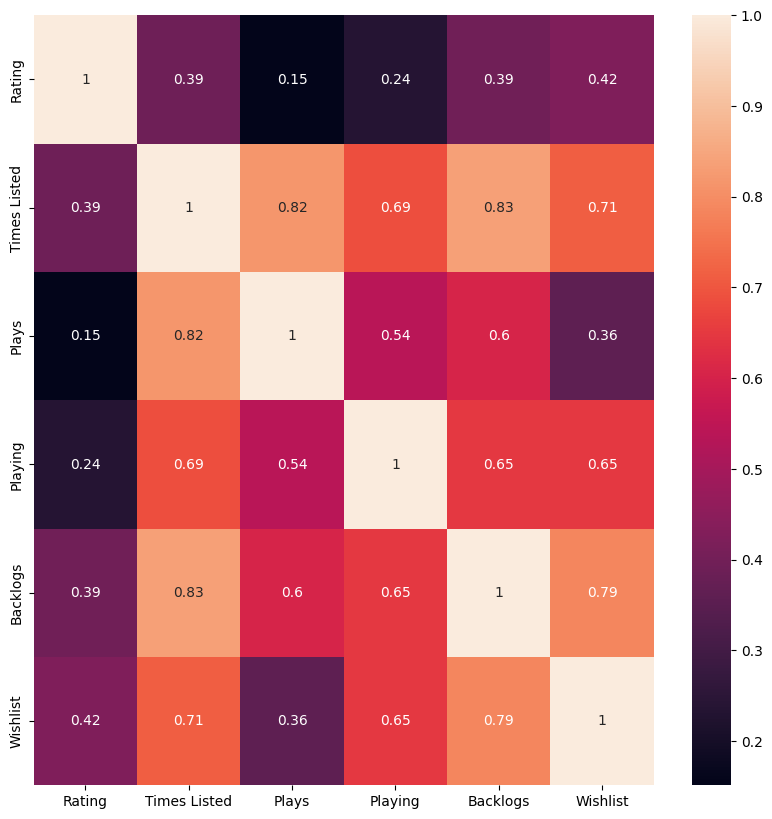

In [249]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

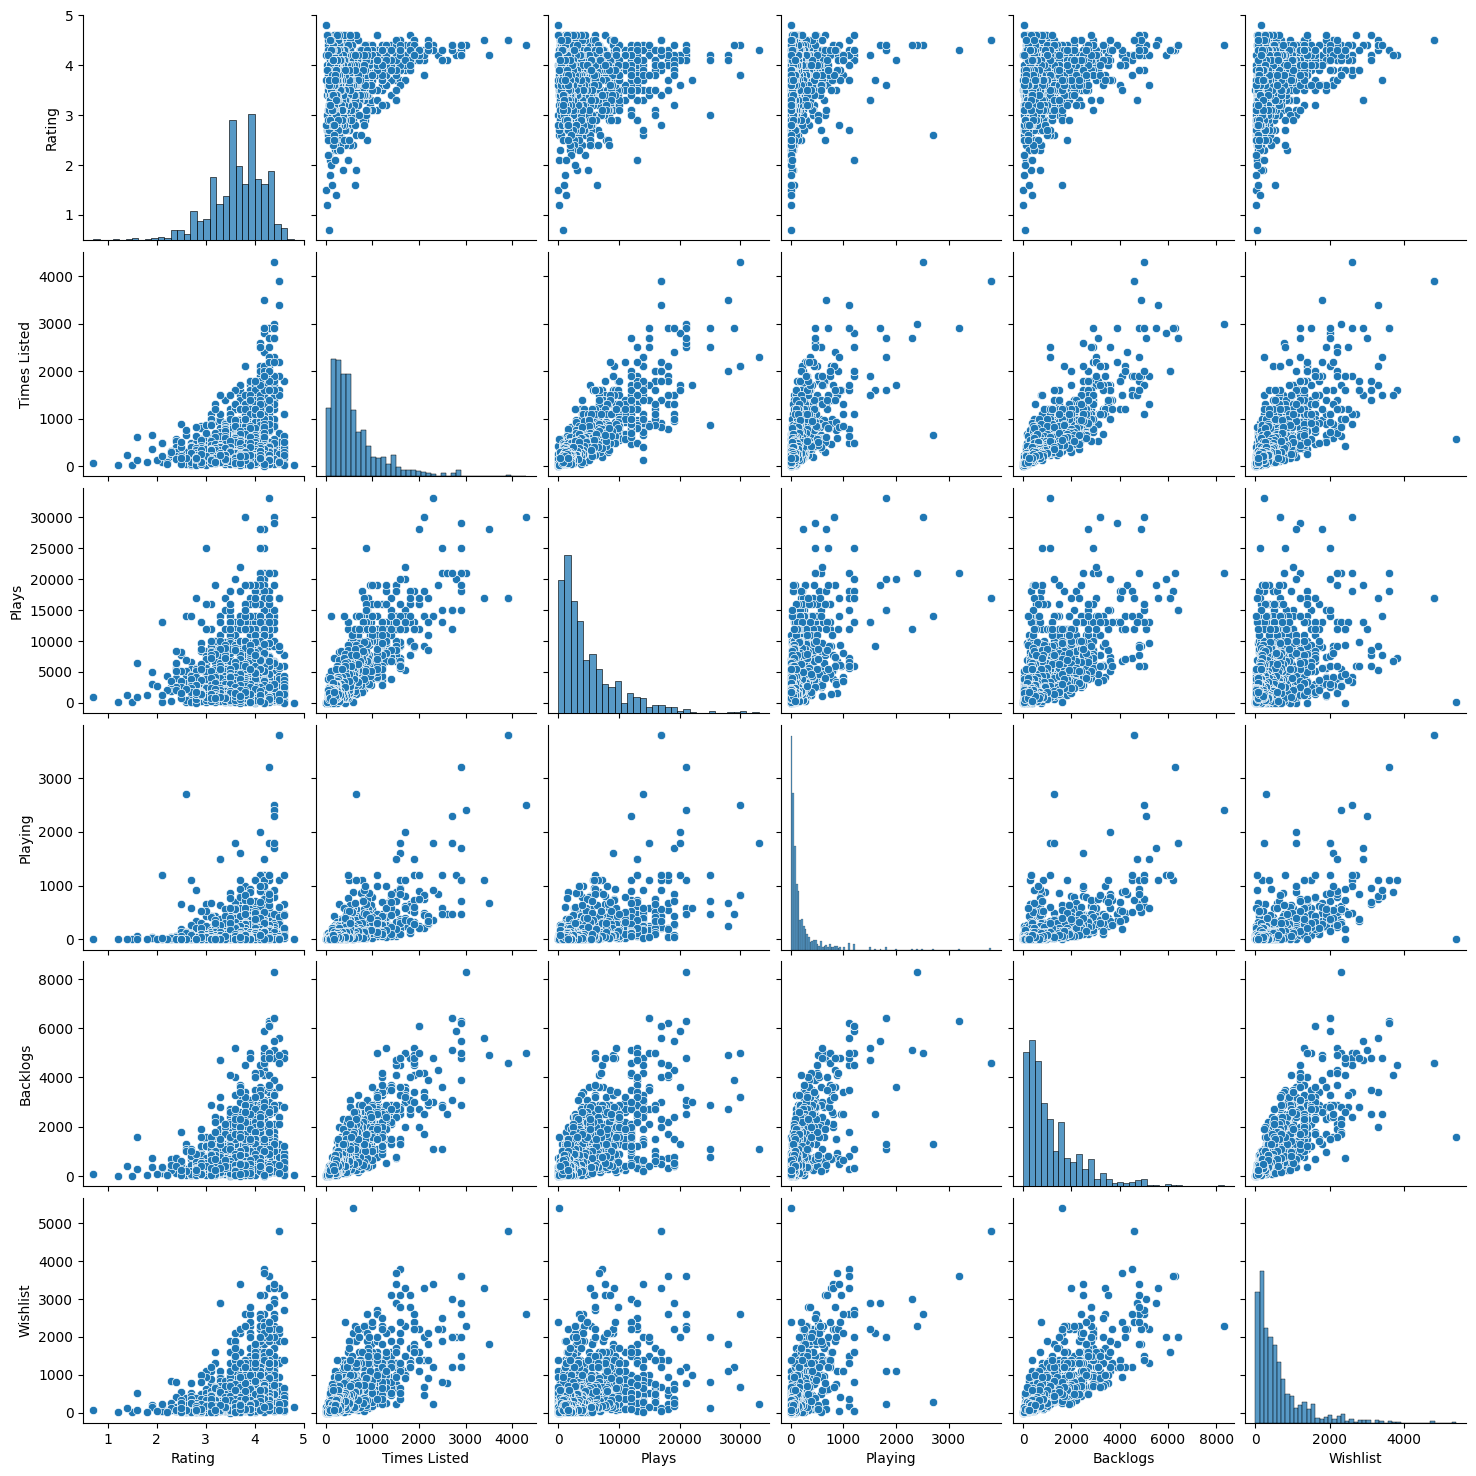

In [250]:
sns.pairplot(df)
plt.show()

## Preprocess pipeline

In [251]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
    
class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, sparse_output=False):
      self.sparse_output = sparse_output
    def fit(self, X, y=None):
      self.enc = MultiLabelBinarizer(sparse_output=self.sparse_output)
      self.enc.fit(x[0] for x in X.values)
      return self
    def transform(self, X, y=None):
      return self.enc.transform(x[0] for x in X.values)


cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Genres"])),
        ("cat_encoder", CustomLabelBinarizer()),
    ])
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Rating", "Times Listed", "Plays", "Playing", "Backlogs"])),
        ("imputer", SimpleImputer(strategy="mean")),
    ])

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

## Train test split

In [252]:
X = df.drop(['Wishlist'], axis=1)
y = df['Wishlist']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.111111, random_state=0)

print(X_train_full.shape, y_train_full.shape)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)
kfold = model_selection.StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

(1017, 6) (1017,)
(904, 6) (904,)
(113, 6) (113,)
(113, 6) (113,)


## LinearRegression

In [253]:
estimator = Pipeline([('preprocess', preprocess_pipeline), ('sc', StandardScaler()), ('pf', PolynomialFeatures(degree=2)),
                       ('regressor', linear_model.LinearRegression())])
param_grid={
    'pf__degree': [1, 2, 3, 4],
    'sc': [None, StandardScaler()]
            }
grid_linear = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=kfold,
                    refit=True)

grid_linear.fit(X_train_full, y_train_full)
print(grid_linear.best_params_)
print("R2: {}".format(metrics.r2_score(y_train_full, grid_linear.predict(X_train_full)) ))

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es)

{'pf__degree': 1, 'sc': StandardScaler()}
R2: 0.7508729892193144


c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(


## Lasso

In [254]:
estimator = Pipeline([('preprocess', preprocess_pipeline), ('sc', StandardScaler()), ('pf', PolynomialFeatures(degree=2)),
                       ('regressor', linear_model.Lasso(alpha=1.0))])
param_grid={
    'pf__degree': [1, 2, 3],
    'sc': [None, StandardScaler()],
    'regressor__alpha': [100000, 10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
            }
grid_lasso = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=kfold,
                    refit=True)

grid_lasso.fit(X_train_full, y_train_full)
print(grid_lasso.best_params_)
print("R2: {}".format(metrics.r2_score(y_train_full, grid_lasso.predict(X_train_full)) ))

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es)

{'pf__degree': 2, 'regressor__alpha': 10, 'sc': StandardScaler()}
R2: 0.8027664877100997


c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.060e+06, tolerance: 3.564e+04
  model = cd_fast.enet_coordinate_descent(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(


## Ridge

In [255]:
estimator = Pipeline([('preprocess', preprocess_pipeline), ('sc', StandardScaler()), ('pf', PolynomialFeatures(degree=2)),
                       ('regressor', linear_model.Ridge(alpha=1.0))])
param_grid={
    'pf__degree': [1, 2, 3],
    'sc': [None, StandardScaler()],
    'regressor__alpha': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
            }
grid_ridge = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=kfold,
                    refit=True)

grid_ridge.fit(X_train_full, y_train_full)
print(grid_ridge.best_params_)
print("R2: {}".format(metrics.r2_score(y_train_full, grid_ridge.predict(X_train_full)) ))

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es)

{'pf__degree': 1, 'regressor__alpha': 100, 'sc': None}
R2: 0.7479195333366087


c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(


## ElasticNet

In [256]:
estimator = Pipeline([('preprocess', preprocess_pipeline), ('sc', StandardScaler()), ('pf', PolynomialFeatures(degree=2)),
                       ('regressor', linear_model.ElasticNet(alpha=1.0))])
param_grid={
    'pf__degree': [1, 2, 3],
    'sc': [None, StandardScaler()],
    'regressor__alpha': [100000, 10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
            }
grid_elastic = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=kfold,
                    refit=True)


grid_elastic.fit(X_train_full, y_train_full)
print(grid_elastic.best_params_)
print("R2: {}".format(metrics.r2_score(y_train_full, grid_elastic.predict(X_train_full)) ))

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es)

{'pf__degree': 2, 'regressor__alpha': 10000, 'sc': None}
R2: 0.8006783327018019


c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.160e+06, tolerance: 3.564e+04
  model = cd_fast.enet_coordinate_descent(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.999e+07, tolerance: 4.520e+04
  model = cd_fast.enet_coordinate_descent(


## XGBRegressor

In [257]:
estimator = Pipeline([('preprocess', preprocess_pipeline), ('sc', StandardScaler()),
                       ('regressor', XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8))])
param_grid={
    'sc': [None, StandardScaler()],
    'regressor__max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    'regressor__subsample': [0.6, 0.7, 0.8],
    'regressor__eta': [0.001, 0.01, 0.1, 0.2, 0.3]
            }
grid_xgb = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=kfold,
                    refit=True)

grid_xgb.fit(X_train_full, y_train_full)
print(grid_xgb.best_params_)
print("R2: {}".format(metrics.r2_score(y_train_full, grid_xgb.predict(X_train_full)) ))

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es)

{'regressor__eta': 0.1, 'regressor__max_depth': 3, 'regressor__subsample': 0.7, 'sc': None}
R2: 0.9950333807542641


## SVR rbf

In [258]:
estimator = Pipeline([('preprocess', preprocess_pipeline), ('sc', StandardScaler()),
                       ('regressor', SVR(kernel='rbf', C=0.01, gamma=0.1))])
param_grid={
    'sc': [None, StandardScaler()],
    'regressor__C': [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.01, 0.1, 1, 10 ,100, 1000, 10000, 100000, 1000000],
    'regressor__gamma': [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.01, 0.1, 1, 10 ,100, 1000, 10000, 100000, 1000000]
            }
grid_svr = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=kfold,
                    refit=True)

grid_svr.fit(X_train_full, y_train_full)
print(grid_svr.best_params_)
print("R2: {}".format(metrics.r2_score(y_train_full, grid_svr.predict(X_train_full))))

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es)

{'regressor__C': 100000, 'regressor__gamma': 1e-08, 'sc': None}
R2: 0.8093505458852509


c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(


## RandomForest

In [280]:
estimator = Pipeline([('preprocess', preprocess_pipeline), ('sc', StandardScaler()),
                       ('regressor', RandomForestRegressor(n_estimators=500, max_depth=20, max_features=3, max_leaf_nodes=10))])
param_grid={
    'sc': [None, StandardScaler()],
    'regressor__max_depth': [25, 50, 100, 150, 200, 250],
    'regressor__max_features': [10, 15, 25, 35, 50, 100],
    'regressor__max_leaf_nodes': [100, 150, 200, 250, 300]
            }
grid_rf = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=kfold,
                    refit=True)

grid_rf.fit(X_train_full, y_train_full)
print(grid_rf.best_params_)
print("R2: {}".format(metrics.r2_score(y_train_full, grid_rf.predict(X_train_full))))

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es)

{'regressor__max_depth': 250, 'regressor__max_features': 15, 'regressor__max_leaf_nodes': 300, 'sc': StandardScaler()}
R2: 0.9708403309709087


# Neural Networks

In [260]:
pipe = make_pipeline(preprocess_pipeline, StandardScaler())

X_train2 = pipe.fit_transform(X_train)
X_Val_2 = pipe.transform(X_val)
X_test2 = pipe.transform(X_test)

## Sequential

In [271]:
ne = Sequential([
    Dense(8000, activation="elu"),
    Dropout(0.5),
    Dense(4000, activation="elu"),
    Dropout(0.5),
    Dense(2000, activation="elu"),
    Dropout(0.5),
    Dense(200, activation="elu"),
    Dropout(0.5),
    Dense(1)
])
early_stopping = EarlyStopping(
    patience=16,
    restore_best_weights=True,
)
ne.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(0.001))

history = ne.fit(X_train2, y_train, epochs=1000, validation_data=(X_Val_2, y_val), verbose=0, batch_size=32,
                    callbacks=[early_stopping])

print(ne.summary())
print("R2: {}".format(metrics.r2_score(y_train, ne.predict(X_train2)) ))

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 8000)              232000    
                                                                 
 dropout_66 (Dropout)        (None, 8000)              0         
                                                                 
 dense_94 (Dense)            (None, 4000)              32004000  
                                                                 
 dropout_67 (Dropout)        (None, 4000)              0         
                                                                 
 dense_95 (Dense)            (None, 2000)              8002000   
                                                                 
 dropout_68 (Dropout)        (None, 2000)              0         
                                                                 
 dense_96 (Dense)            (None, 200)             

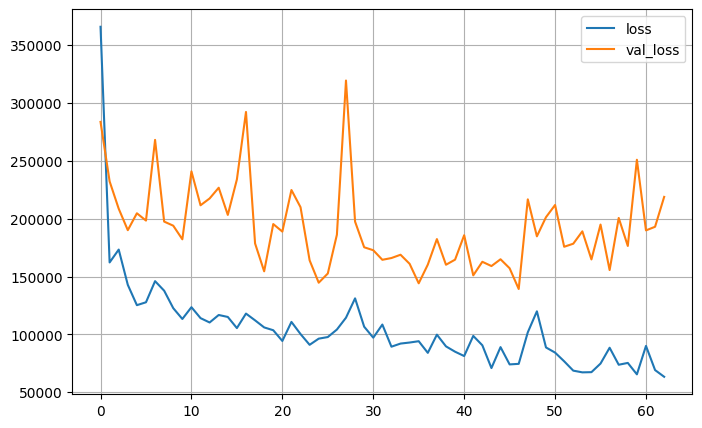

In [281]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

## Sequential with convolutions

In [263]:
ne_conv = Sequential([
    Dense(8000, activation="elu"),
    Reshape((20, 20, 20)),
    Conv2D(100, (5, 5), activation="elu"),
    AveragePooling2D(),
    Conv2D(100, (5, 5), activation="elu", strides=(2, 2)),
    AveragePooling2D(),
    Flatten(),
    Dense(1000, activation="elu"),
    Dropout(0.5),
    Dense(100, activation="elu"),
    Dropout(0.5),
    Dense(1)
])

early_stopping = EarlyStopping(
    patience=16,
    restore_best_weights=True,
)

ne_conv.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(0.001))

history = ne_conv.fit(X_train2, y_train, epochs=1000, validation_data=(X_Val_2, y_val), verbose=0, batch_size=8,
                    callbacks=[early_stopping])

print(ne_conv.summary())
print("R2: {}".format(metrics.r2_score(y_train, ne_conv.predict(X_train2)) ))

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_89 (Dense)            (None, 8000)              232000    
                                                                 
 reshape_6 (Reshape)         (None, 20, 20, 20)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 100)       50100     
                                                                 
 average_pooling2d_12 (Avera  (None, 8, 8, 100)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_13 (Conv2D)          (None, 2, 2, 100)         250100    
                                                                 
 average_pooling2d_13 (Avera  (None, 1, 1, 100)        0         
 gePooling2D)                                        

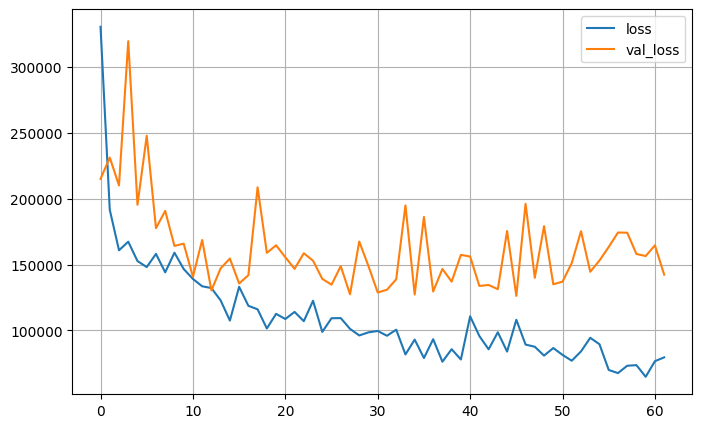

In [264]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

# Visualization

In [282]:
grid = [
    ('Lin_reg', grid_linear, X_train_full, y_train_full, X_test, y_test),
    ('Lasso', grid_lasso, X_train_full, y_train_full, X_test, y_test),
    ('Ridge', grid_ridge, X_train_full, y_train_full, X_test, y_test),
    ('Elastic', grid_elastic, X_train_full, y_train_full, X_test, y_test),
    ('Xgb', grid_xgb, X_train_full, y_train_full, X_test, y_test),
    ('Svr', grid_svr, X_train_full, y_train_full, X_test, y_test),
    ('RForest', grid_rf, X_train_full, y_train_full, X_test, y_test),
    ('Ne', ne, X_train2, y_train, X_test2, y_test),
    ('Ne_Conv', ne_conv, X_train2, y_train, X_test2, y_test)
]

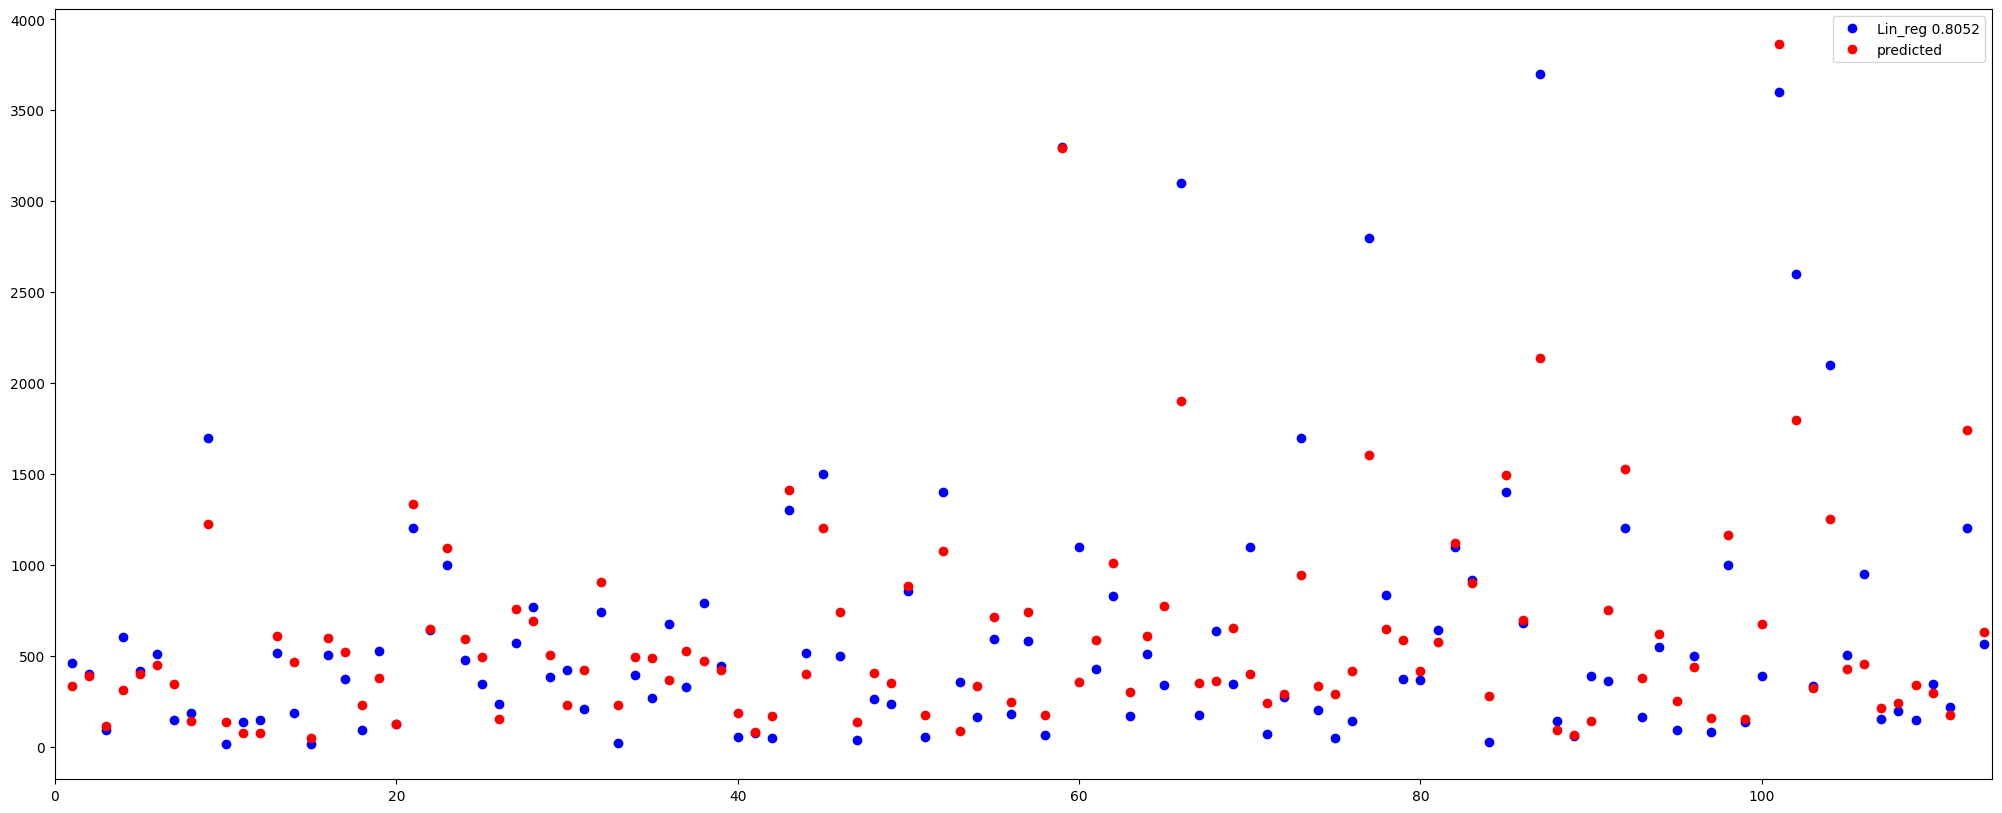

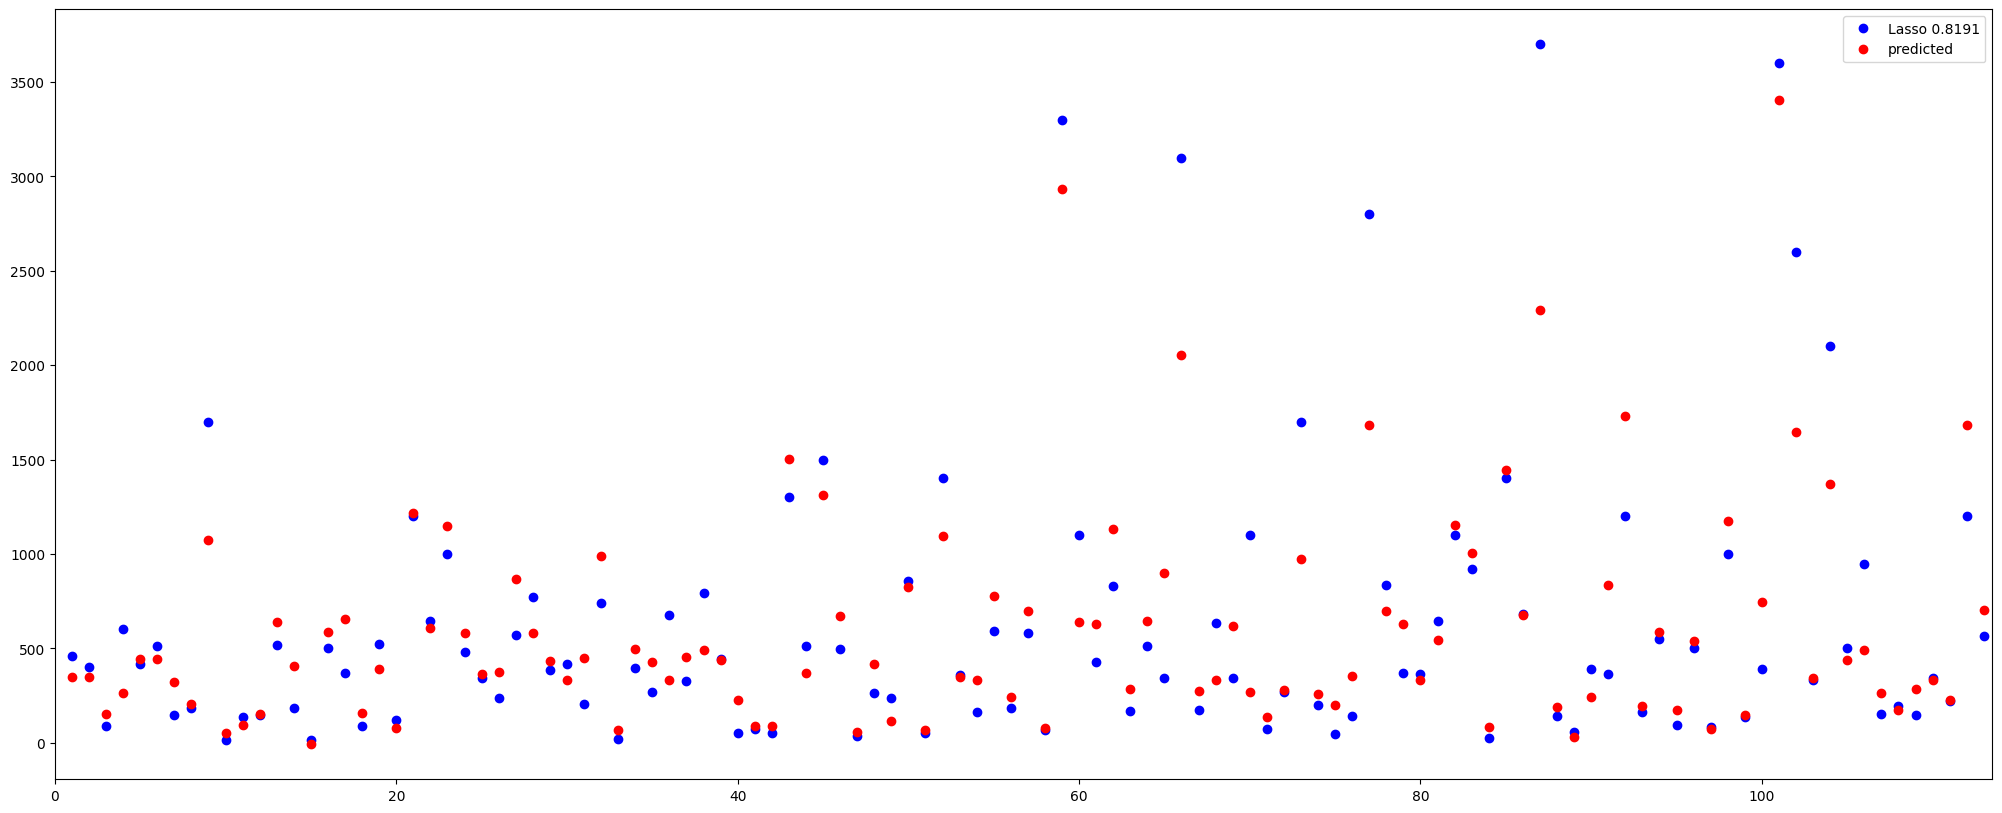

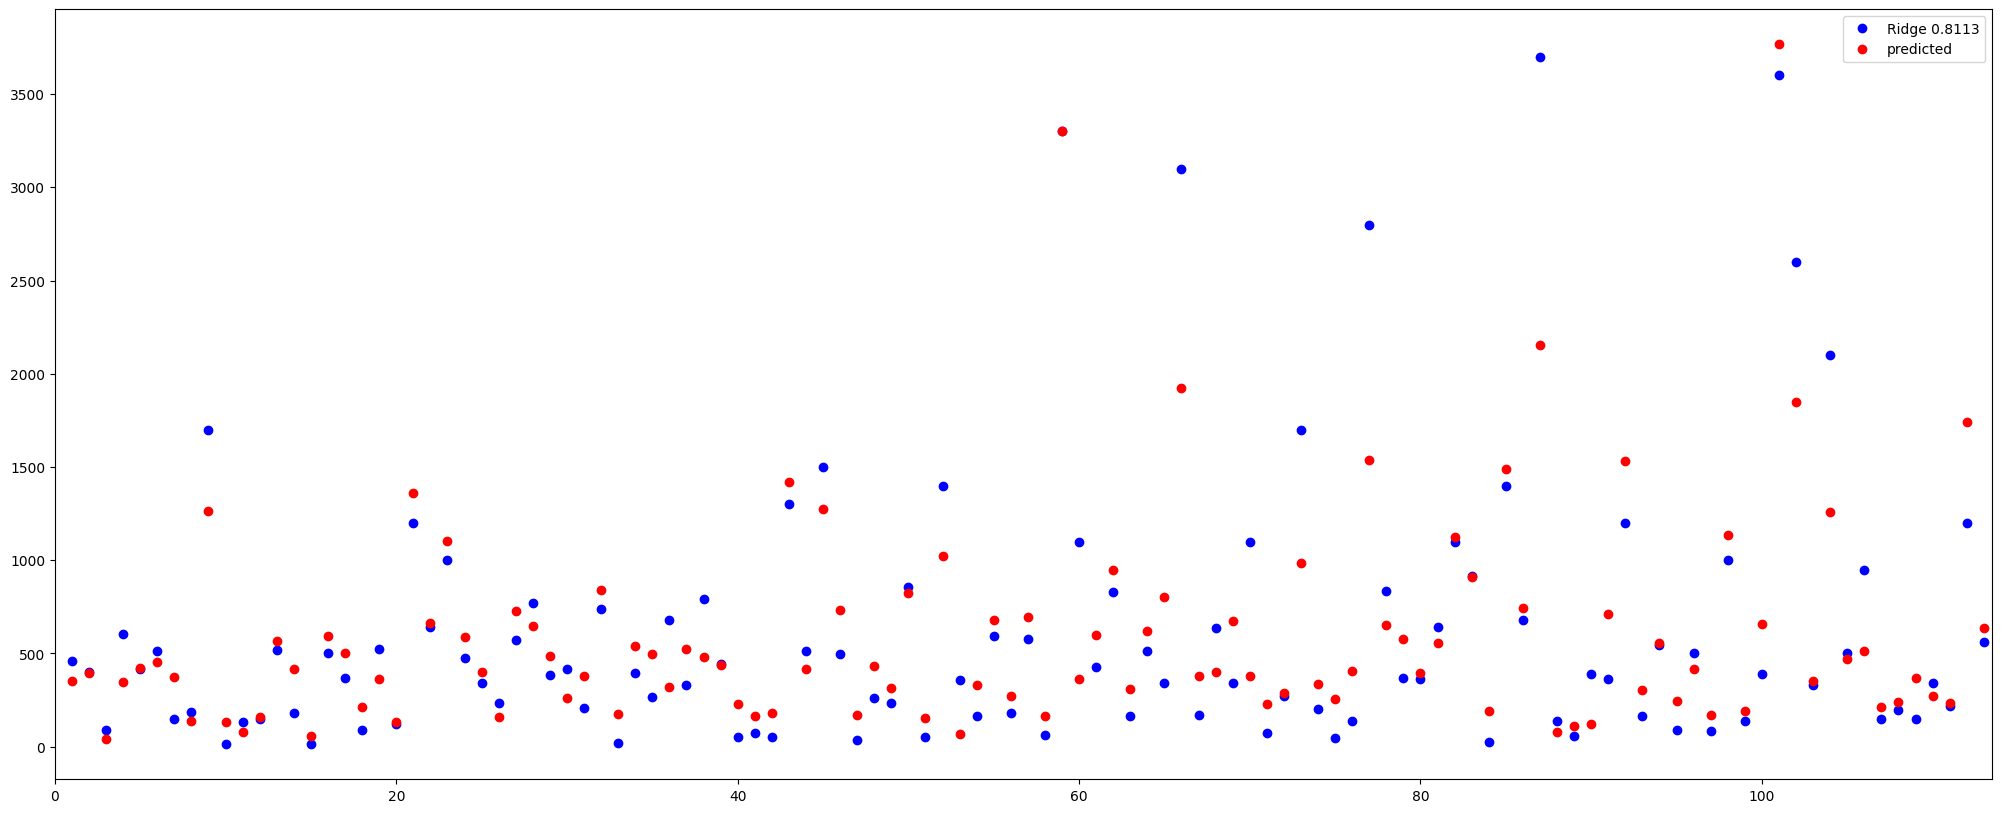

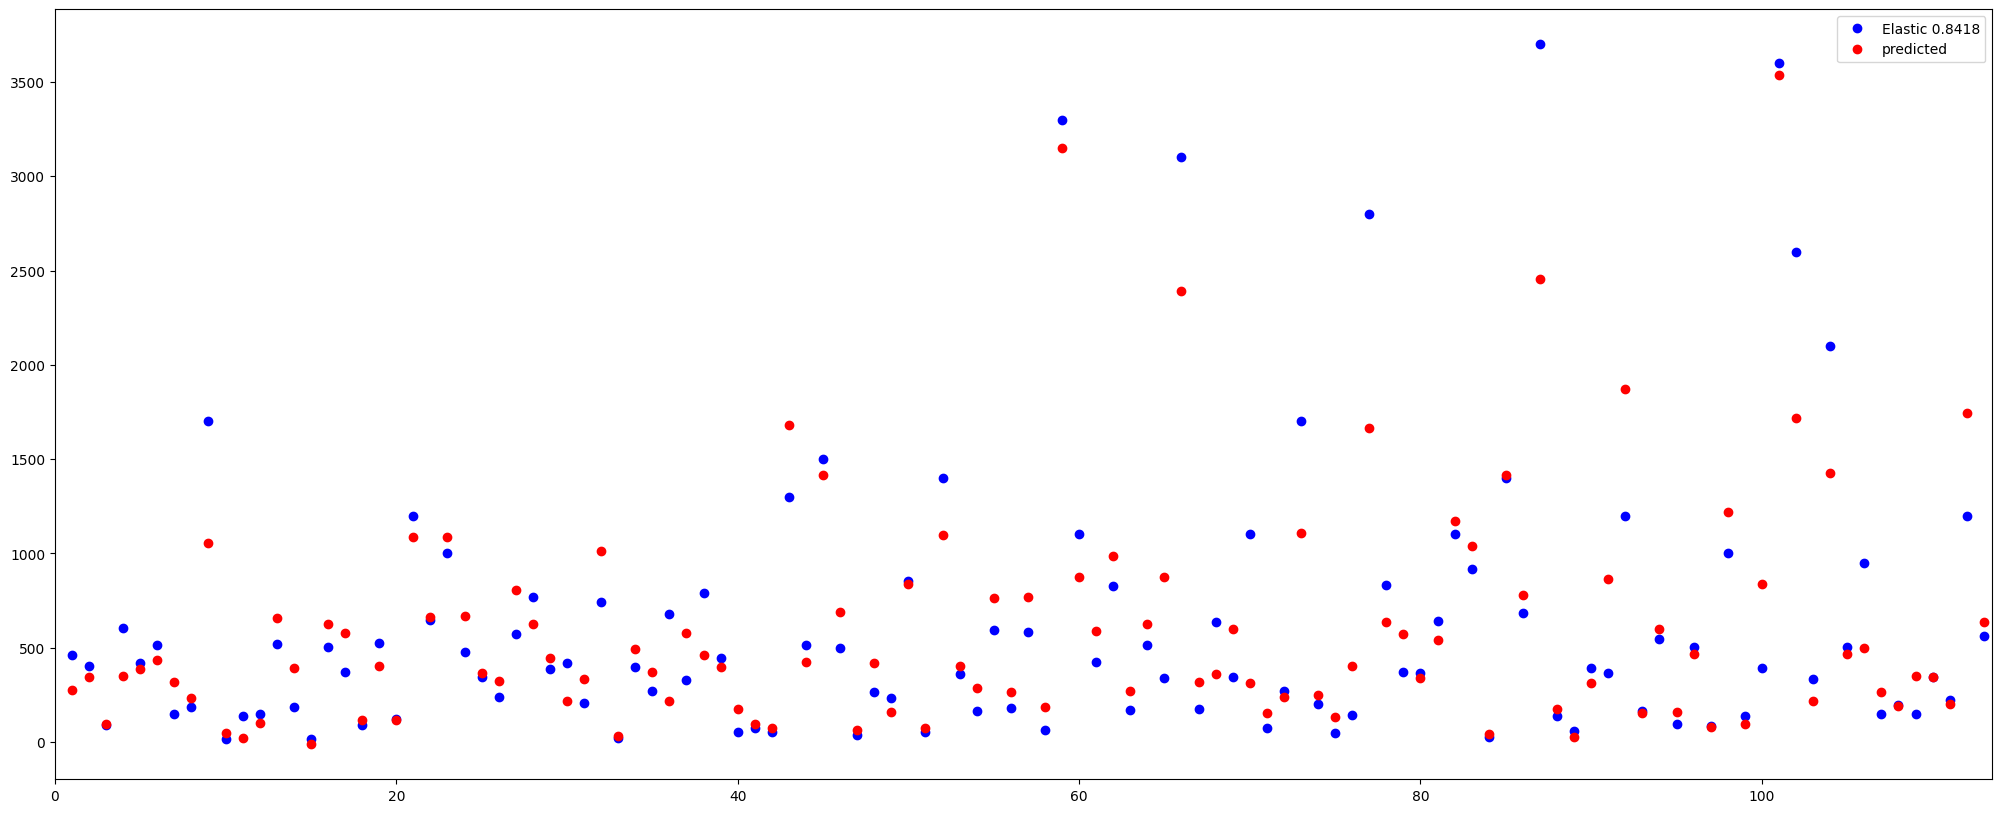

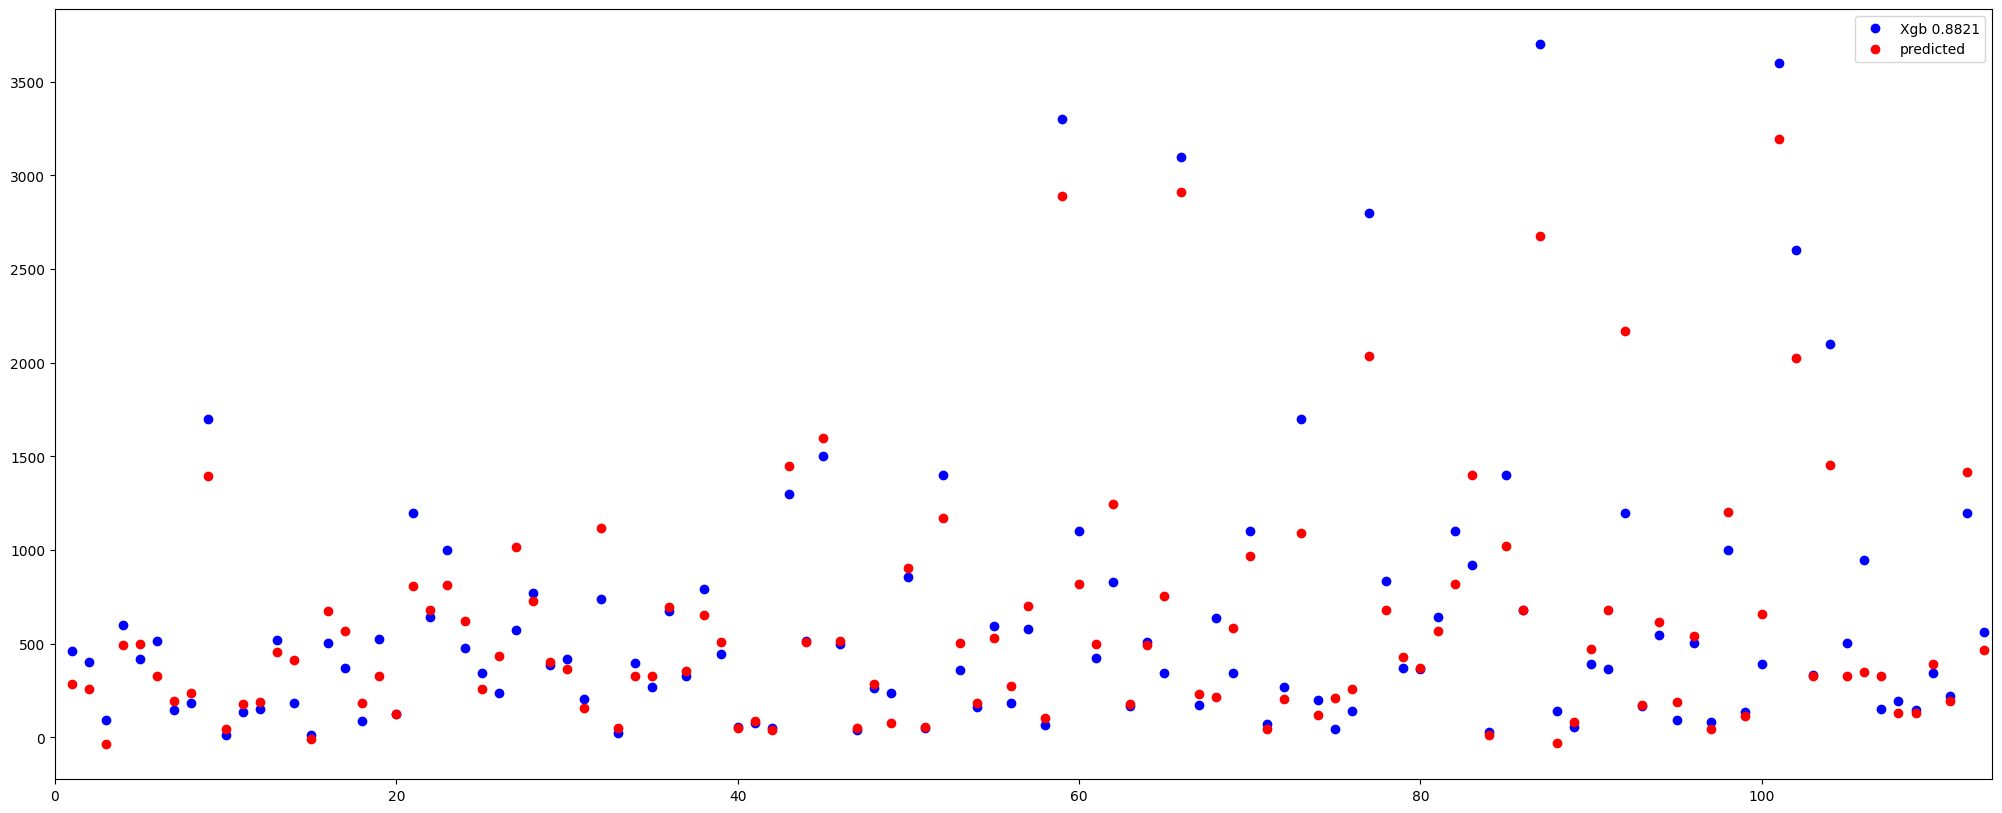

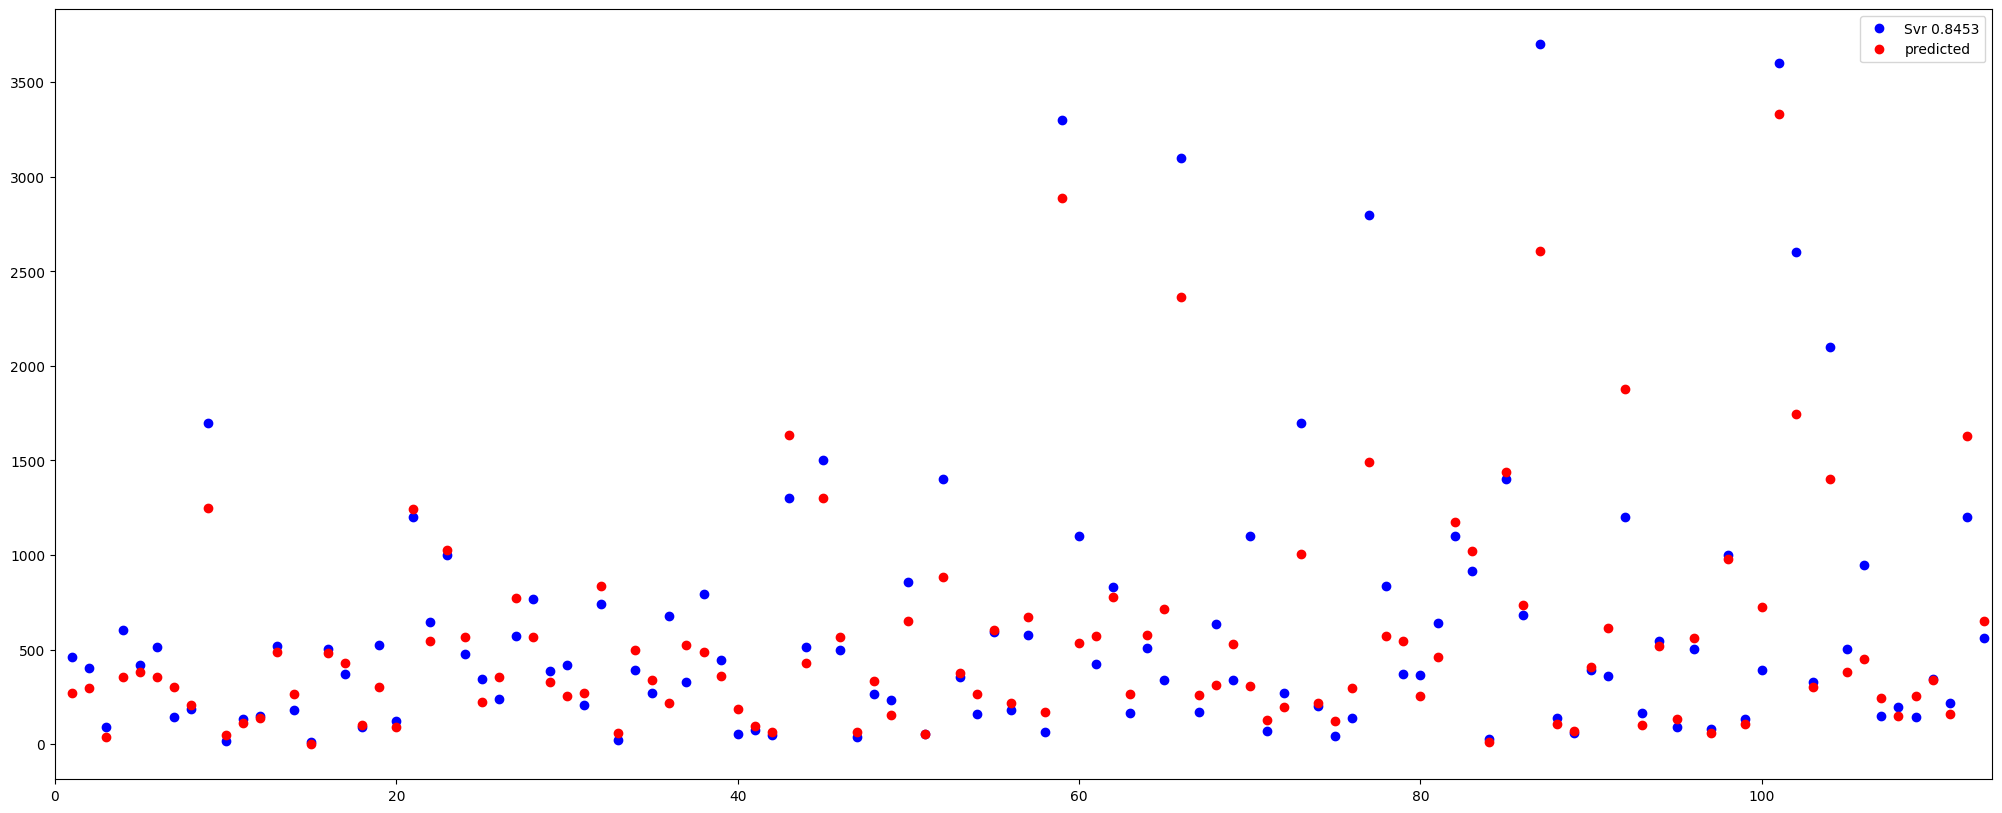

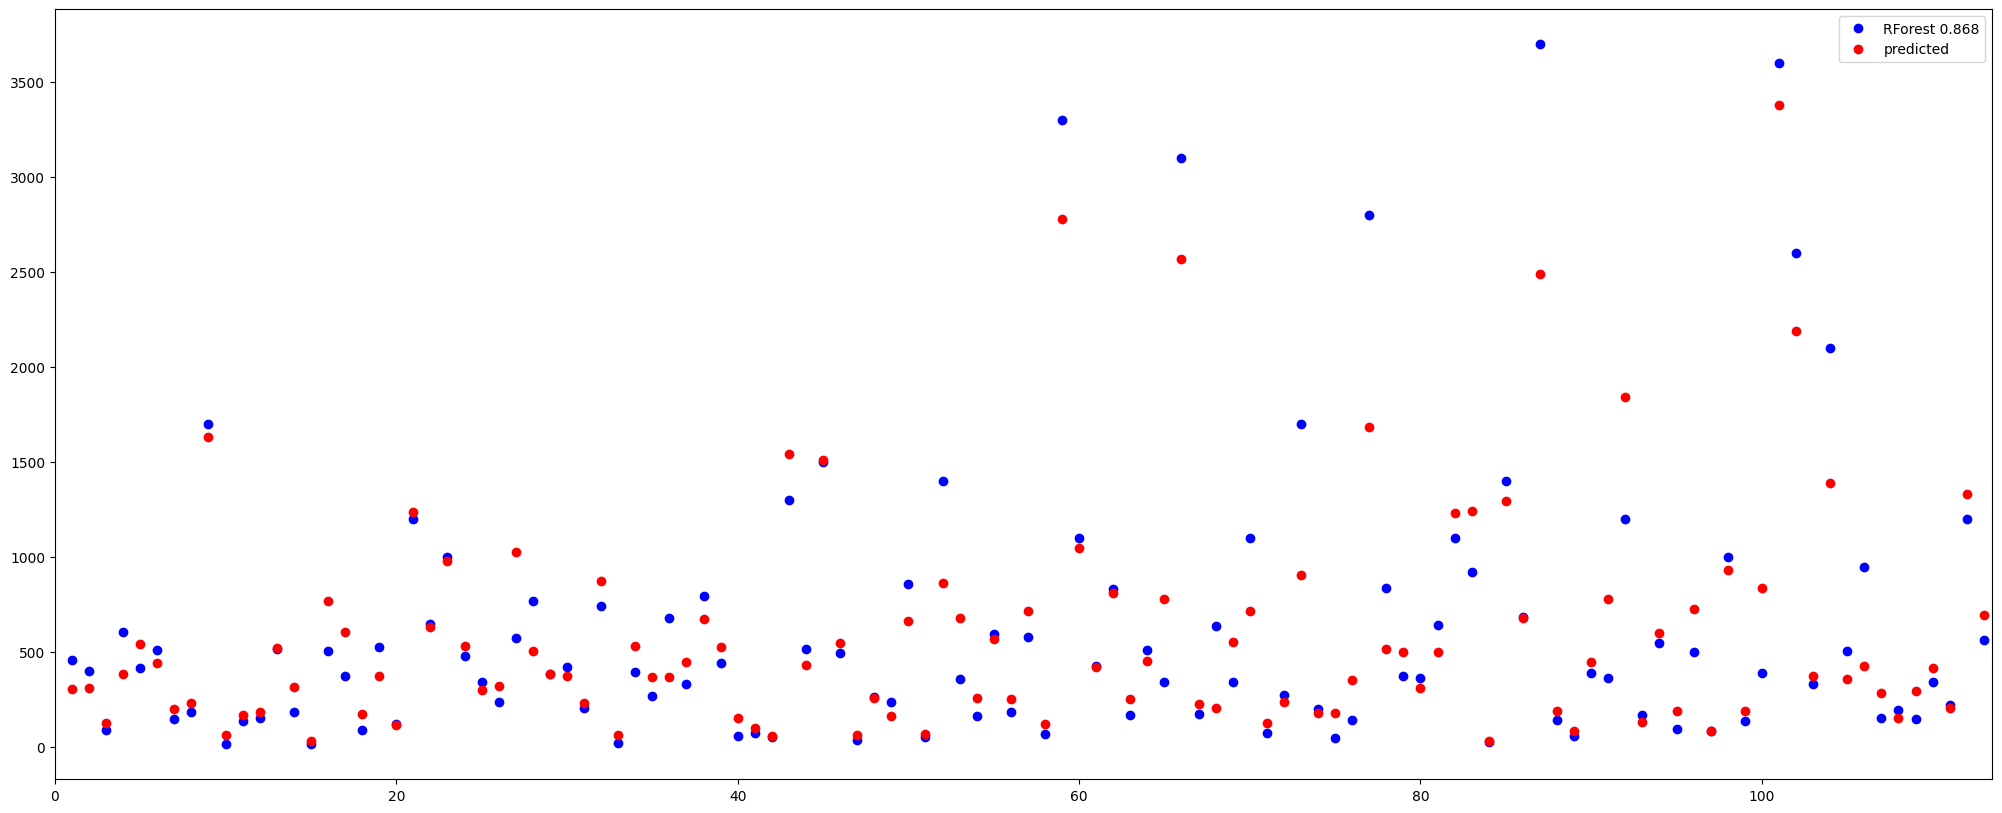

4/4 [==============================] - 0s 11ms/step


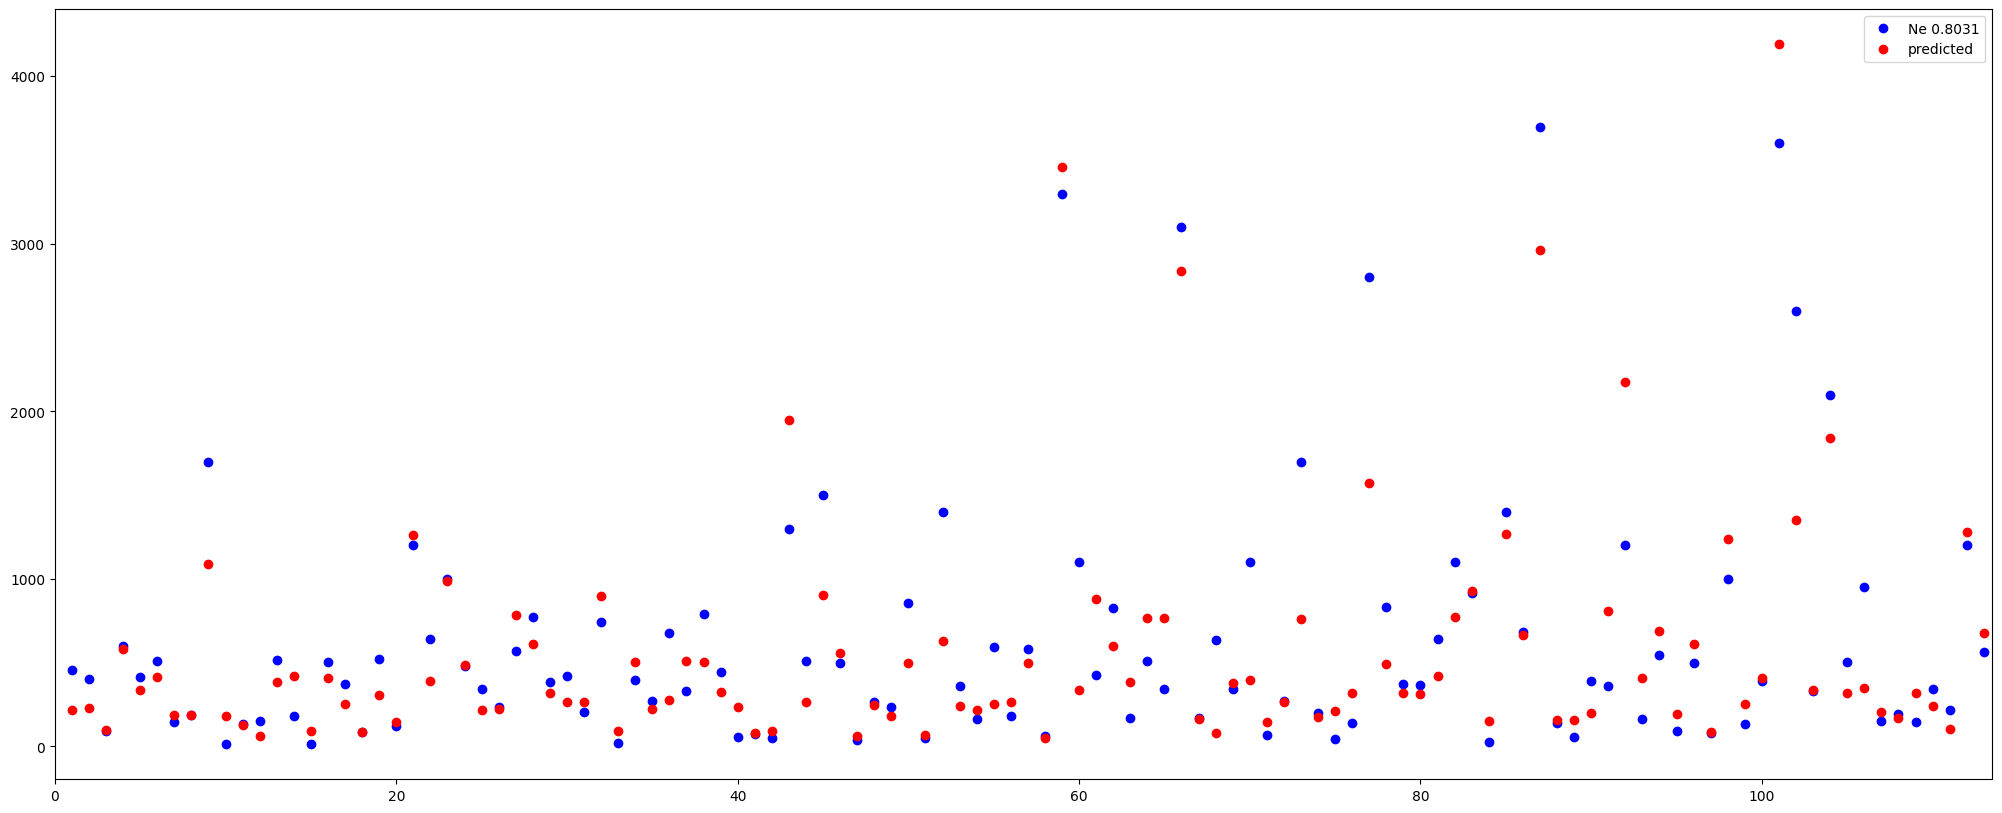

4/4 [==============================] - 0s 6ms/step


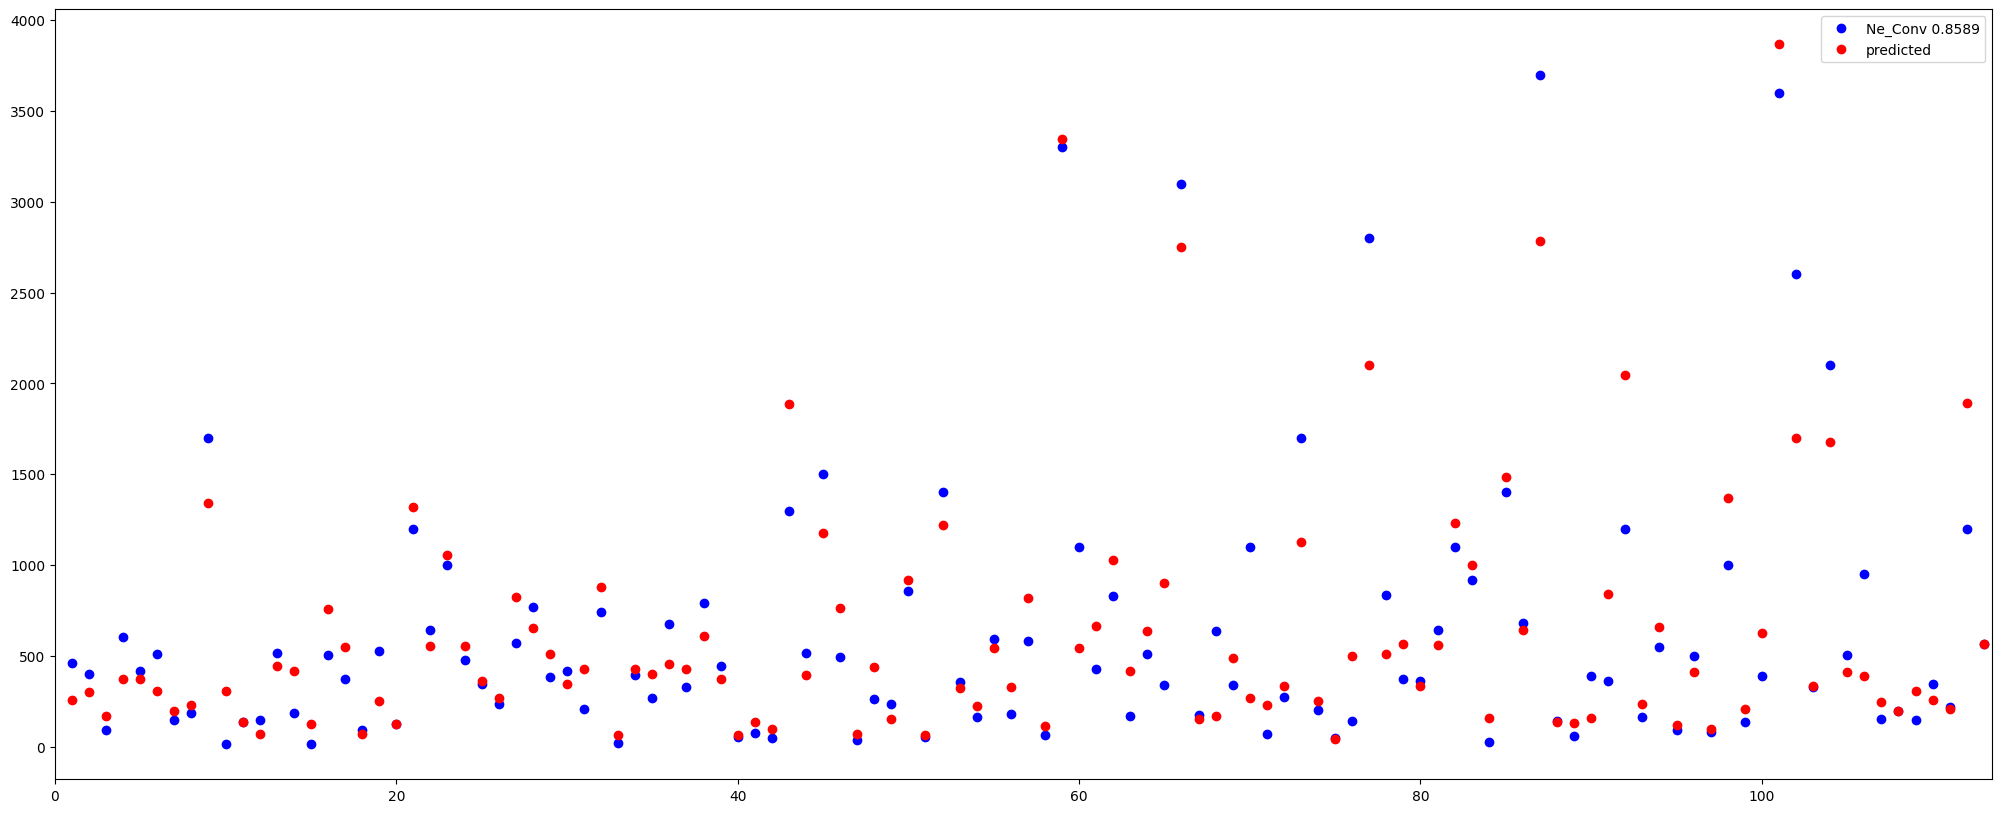

In [283]:
for name, model, _, _, x_test, y_test in grid:
    predicted = model.predict(x_test)
    plt.figure(figsize=(25, 10))
    plt.xlim(0, 113.5)
    plt.plot(np.arange(1, len(y_test) + 1), y_test, 'bo')
    plt.plot(np.arange(1, len(y_test) + 1), predicted, 'ro')
    plt.legend([name + ' ' + str(round(metrics.r2_score(y_test, predicted), 4)), 'predicted'])
    plt.show()

# Summary

In [284]:
method = []
r2_train = []
explained_variance_score_train = []
median_absolute_error_train = []
mean_squared_error_train = []
mean_absolute_error_train = []

for name, model, x_train, y_train, _, _ in grid:
    predicted = model.predict(x_train)
    r2_train.append(metrics.r2_score(y_train, predicted))
    method.append(name)
    explained_variance_score_train.append(metrics.explained_variance_score(y_train, predicted))
    median_absolute_error_train.append(metrics.median_absolute_error(y_train, predicted))
    mean_squared_error_train.append(metrics.mean_squared_error(y_train, predicted))
    mean_absolute_error_train.append(metrics.mean_absolute_error(y_train, predicted))

29/29 [==============================] - 0s 6ms/step


In [285]:
r2_test = []
explained_variance_score_test = []
median_absolute_error_test = []
mean_squared_error_test = []
mean_absolute_error_test = []

for name, model, _, _, x_test, y_test in grid:
    predicted = model.predict(x_test)
    r2_test.append(metrics.r2_score(y_test, predicted))
    explained_variance_score_test.append(metrics.explained_variance_score(y_test, predicted))
    median_absolute_error_test.append(metrics.median_absolute_error(y_test, predicted))
    mean_squared_error_test.append(metrics.mean_squared_error(y_test, predicted))
    mean_absolute_error_test.append(metrics.mean_absolute_error(y_test, predicted))

4/4 [==============================] - 0s 6ms/step


## Train

In [286]:
cols = {'Method': method,
     'r2': r2_train, 
     'explained_variance_score': explained_variance_score_train, 
     'median_absolute_error': median_absolute_error_train,
     'mean_squared_error' : mean_squared_error_train,
     'mean_absolute_error' : mean_absolute_error_train,
    }
summary = pd.DataFrame(data=cols)
summary.sort_values(by=['r2'], ascending=False)

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
4,Xgb,0.995033,0.995034,26.866436,2207.219182,35.104187
6,RForest,0.970840,0.970849,41.164545,12958.871543,68.662628
7,Ne,0.862828,0.862922,93.071609,59092.053043,149.779523
8,Ne_Conv,0.853393,0.858645,101.238785,63156.528281,158.702874
5,Svr,0.809351,0.812551,83.429575,84726.674477,158.586783
1,Lasso,0.802766,0.802766,108.666758,87652.700971,175.666667
3,Elastic,0.800678,0.800678,114.844089,88580.699588,178.112218
0,Lin_reg,0.750873,0.750873,137.065427,110714.731621,206.111084
2,Ridge,0.747920,0.747920,136.782829,112027.279282,206.136373


## Test

In [287]:
cols = {'Method': method,
     'r2': r2_test, 
     'explained_variance_score': explained_variance_score_test, 
     'median_absolute_error': median_absolute_error_test,
     'mean_squared_error' : mean_squared_error_test,
     'mean_absolute_error' : mean_absolute_error_test,
    }
summary = pd.DataFrame(data=cols)
summary.sort_values(by=['r2'], ascending=False)

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
4,Xgb,0.882079,0.883232,84.121521,64058.476990,162.229975
6,RForest,0.868038,0.868962,83.892444,71686.210928,163.658937
8,Ne_Conv,0.858929,0.858936,111.865707,76634.460393,186.958674
5,Svr,0.845325,0.852918,88.632613,84024.687885,175.426335
3,Elastic,0.841763,0.842223,114.056279,85959.456224,185.459944
1,Lasso,0.819121,0.820288,120.150347,98259.154058,193.364568
2,Ridge,0.811267,0.811998,128.500242,102525.967323,200.330188
0,Lin_reg,0.805217,0.805858,134.452827,105812.420668,206.789770
7,Ne,0.803073,0.810619,119.240784,106977.111772,208.898664
